# Multiomics Cancer Classification

## Overview of the tutorial

### Introduction
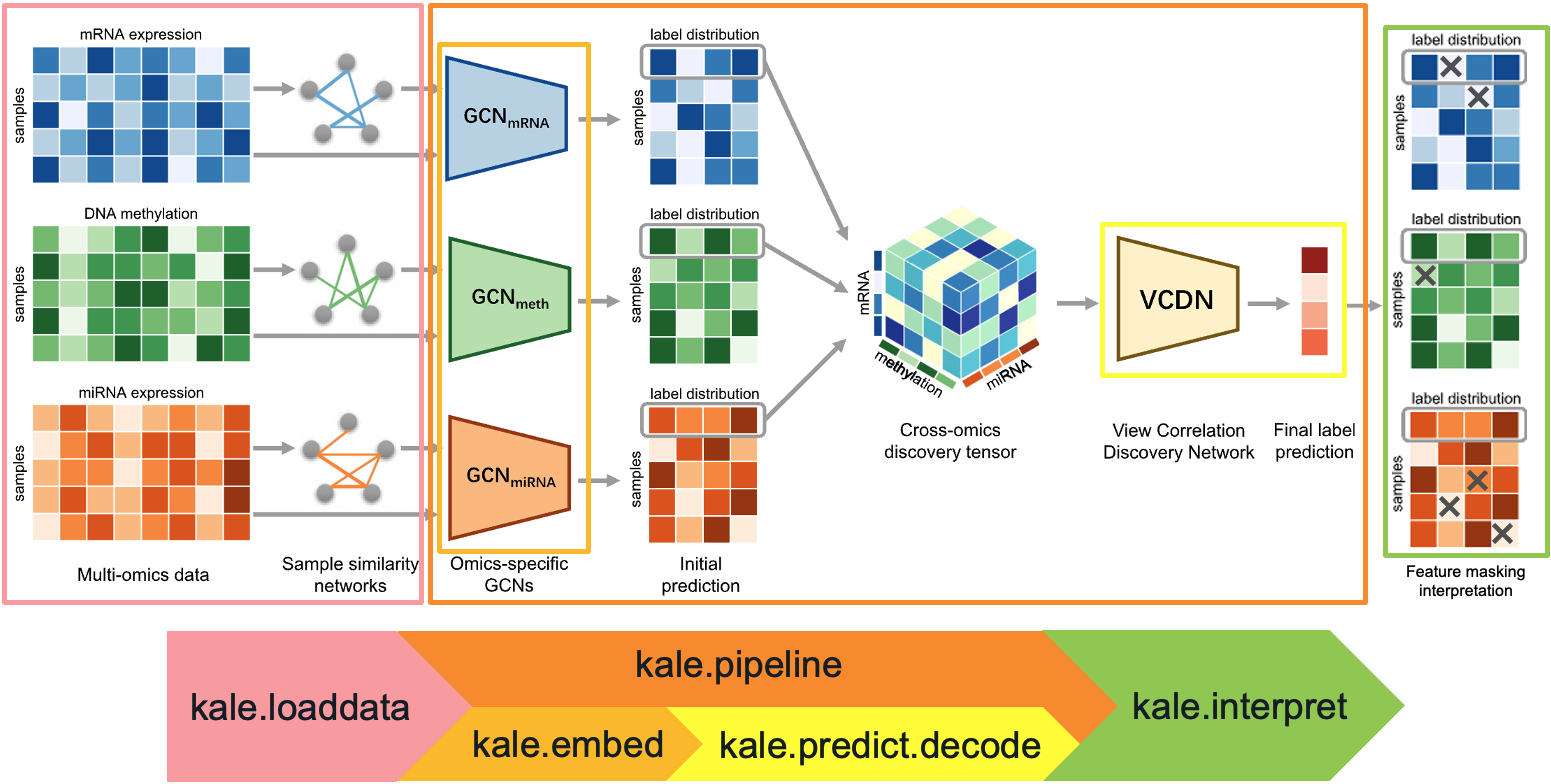

In this tutorial, we demonstrate the standard pipeline in `PyKale`and the power of multimodal data by integrating **patient multiomics data** to enhance **cancer classification**.

This notebook builds on the work of **Huang et al. (Nature Communication, 2021)**, which present a novel multi-omics integrative method named **M**ulti-**O**mics **G**raph c**O**nvolutional **NET**works (MOGONET) and jointly explores omics-specific learning and cross-omics correlation learning for effective multiomics data classification by including mRNA expression data, DNA methylation data, and miRNA expression data.

### Problem Formulation

This tutorial is about cancer subtypes classification problem, which is a multi-class classification problem. The input is the multiomics data from patient, while the output will be the subtype of cancers. We have two datasets to work with, **BRCA** and **ROSMAP**. BRCA has five subtypes and ROSMAP has only two.

### Objective

- Understand the advantages of multimodal data compared to the unimodal data.
- Understand the standard pipeline of `PyKale` library.

## Environment Preparation

As a starting point, we will install the required packages and load a set of helper functions to assist throughout this tutorial. To keep the output clean and focused on interpretation, we will also suppress warnings.

Moreover, we provide helper functions that can be inspected directly in the `.py` files located in the notebook's current directory. Two additional helper scripts are:
- [`config.py`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/multiomics-cancer-classification/config.py): Defines the base configuration settings, which can be overridden using a custom `.yaml` file.
- [`model.py`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/multiomics-cancer-classification/model.py): Defines the network structure of MOGONET.

### Package Installation

The main packages required for this tutorialare PyKale and PyTorch Geometric.

`PyKale` is an open-source interdisciplinary machine learning library developed at the University of Sheffield, with a focus on applications in biomedical and scientific domains.

`PyG` (PyTorch Geometric) is a library built upon `PyTorch` to easily write and train Graph Neural Networks (GNNs) for a wide range of applications related to structured data.

Other required packages can be found in [`embc-mmai25/requirements.txt`](https://github.com/pykale/embc-mmai25/blob/main/requirements.txt).

--------------------------------------------------------------------------------

#### **WARNINGS**
Please don't re-run this session after installation completed. Runing this installation multiple times will trigger issues related to `PyG`. If you want to re-run this installation, please click the `Runtime` on the top menu and choose `Disconnect and delete runtime` before installing.

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"
!rm -rf /content/embc-mmai25
!git clone https://github.com/pykale/embc-mmai25.git

%cd /content/embc-mmai25/tutorials/multiomics-cancer-classification

!pip install --quiet git+https://github.com/pykale/pykale@main\
    && echo "PyKale installed successfully ✅" \
    || echo "Failed to install PyKale ❌"
!pip install --quiet -r /content/embc-mmai25/requirements.txt \
    && echo "Required packages installed successfully ✅" \
    || echo "Failed to install required packages ❌"
import torch
import os
os.environ['TORCH'] = torch.__version__
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git \
    && echo "PyG installed successfully ✅" \
    || echo "Failed to install PyG ❌"
!pip install --upgrade --force-reinstall numpy==2.0.0
os.kill(os.getpid(), 9)

### Configuration

To minimize the footprint of the notebook when specifying configurations, we provide a [`config.py`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/multiomics-cancer-classification/config.py) file that defines default parameters. These can be customized by supplying a `.yaml` configuration file, such as [`experiments/base.yaml`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/multiomics-cancer-classification/experiments/base.yaml) as an example.
Besides, we also provide a configuration file for another dataset **ROSMAP**, named [`experiments/MOGONET_ROSMAP_quick_test.yaml`](https://github.com/pykale/embc-mmai25/blob/main/tutorials/multiomics-cancer-classification/experiments/MOGONET_ROSMAP_quick_test.yaml). Users can try with this dataset later.

In this tutorial, we list the hyperparameters we would like users to play with outside the `.yaml` file:
- `cfg.SOLVER.MAX_EPOCHS_PRETRAIN`: Number of epochs in pre-training stage.
- `cfg.SOLVER.MAX_EPOCHS`: Number of epochs in training stage.
- `cfg.DATASET.NUM_MODALITIES`: Number of modalities in the pipeline.
  - `1`: mRNA expression.
  - `2`: mRNA expression + DNA methylation.
  - `3`: mRNA expression + DNA methylation + miRNA expression.

In [ ]:
%cd /content/embc-mmai25/tutorials/multiomics-cancer-classification

from config import get_cfg_defaults

cfg = get_cfg_defaults()

# To try ROSMAP, replace "experiments/base.yaml" with "experiments/MOGONET_ROSMAP_quick_test.yaml" in the following line.
cfg.merge_from_file("experiments/base.yaml")

# ------ Hyperparameters to play with -----
# User can reduce the training epochs to decrease training time if necessary.
cfg.SOLVER.MAX_EPOCHS_PRETRAIN = 500
cfg.SOLVER.MAX_EPOCHS = 2500
# User can change this to try different numbers of modalities.
cfg.DATASET.NUM_MODALITIES = 3
# -----------------------------------------
print(cfg)

## Data Loading and Pre-processing

We use two multiomics benchmark in this tutorial, BRCA and ROSMAP, which have been provided by the authors of MOGONET paper in [their repository](https://github.com/txWang/MOGONET).
A brief description of BRCA and ROSMAP dataset is shown in the following
table.

**Table 1**: Characteristics of the preprocessed ROSMAP multiomics dataset.

|      Omics       | #Training samples | #Test samples | #Features  |
|:----------------:|:-----------------:|:-------------:|:----------:|
| mRNA expression  |        245        |      106      |    200     |
| DNA methylation  |        245        |      106      |    200     |
| miRNA expression |        245        |      106      |    200     |



**Table 2**: Characteristics of the preprocessed BRCA multiomics dataset.

|      Omics       | #Training samples | #Test samples | #Features |
|:----------------:|:-----------------:|:-------------:|:---------:|
| mRNA expression  |        612        |      263      |   1000    |
| DNA methylation  |        612        |      263      |   1000    |
| miRNA expression |        612        |      263      |    503    |

We use `kale.loaddata.multiomics_datasets.SparseMultiomicsDataset` to load data from the raw `.csv` files and pre-process them to the graphs we needed.

This function transforms tabular multiomics data into graph datasets by treating each patient sample as a node and using molecular measurements as node features. For each modality, it reads feature matrices and labels from `.csv` files, splits them into training and test sets.

Then, it samples similaity networks from the graphs as shown in the top figure. It computes sample similarities to define edges between nodes. These similarities are used to construct sparse adjacency matrices, where only the most relevant connections are retained.

Next, each graph is represented with node features, edge connections, and labels, encapsulating both feature and relational structure for downstream graph-based learning.



In [ ]:
import torch
from kale.loaddata.multiomics_datasets import SparseMultiomicsDataset
from kale.prepdata.tabular_transform import ToOneHotEncoding, ToTensor

print("\n==> Preparing dataset...")
file_names = []
for modality in range(1, cfg.DATASET.NUM_MODALITIES + 1):
    file_names.append(f"{modality}_tr.csv")
    file_names.append(f"{modality}_lbl_tr.csv")
    file_names.append(f"{modality}_te.csv")
    file_names.append(f"{modality}_lbl_te.csv")
    file_names.append(f"{modality}_feat_name.csv")

multiomics_data = SparseMultiomicsDataset(
    root=cfg.DATASET.ROOT,
    raw_file_names=file_names,
    num_modalities=cfg.DATASET.NUM_MODALITIES,
    num_classes=cfg.DATASET.NUM_CLASSES,
    edge_per_node=cfg.MODEL.EDGE_PER_NODE,
    url=cfg.DATASET.URL,
    random_split=cfg.DATASET.RANDOM_SPLIT,
    equal_weight=cfg.MODEL.EQUAL_WEIGHT,
    pre_transform=ToTensor(dtype=torch.float),
    target_pre_transform=ToOneHotEncoding(dtype=torch.float),
)

print(multiomics_data)

## Model Definition

MOGONET consists of two major sections: modality-specific encoders to encode graph data into latent space, and View Correlation Discovery Network (VCDN) for multimodal feature fusion. We integrate the modalitity-specific encoders in `kale.embed` and VCDN along with the prediction head in `kale.predict`.

We define `MogonetModel` class in `model.py`, which wraps all the necessary components of the MOGONET pipeline based on the configuration.
This wrapper takes care of:
- Building GCN encoders for each omics modality.
- Creating linear classifiers for modality-specific outputs.
- Optionally initializing a VCDN decoder for multimodal fusion.

### Embed

MOGONET applies graph convolutional neural networks (GCNs) as the modality-specific encoders. GCNs are neural networks designed for graph data, which generalize convolution operations to graph-structured data by aggregating feature information from neighboring nodes. In `PyKale`, we integrate GCN layer in `kale.embed` and stack the GCN layers into MOGONET encoder in `kale.embed.mogonet.MogonetGCN`. Finally, `MogonetModel` class in `model.py` wraps the MOGONET encoders in the pipeline.

### Predict

We integrate the VCDN in `kale.predict.decode.VCDN`, which which fuses modality-specific predictions into a joint representation for final classification. It captures correlations between different modalities at the decision level.

We also call the linear classifier layer from `kale.predict.decode.LinearClassifier`, which provides a lightweight feedforward decoder for classifying features extracted from each modality. It is used after each unimodal encoder to make modality-specific predictions.

### Descriptions of Other APIs in `model.py`

`model.py` also calls `kale.pipeline.multiomics_trainer`, which provides `MultiomicsTrainer`, the training and evaluation engine that orchestrates how unimodal encoders, decoders, and the multimodal VCDN fusion layer work together. It supports pretraining and full training regimes.

In [ ]:
from model import MogonetModel

mogonet_model = MogonetModel(cfg, dataset=multiomics_data)

## Model Training

### Pretrain Unimodal Encoders

Before training the multiomics model, we first pretrain encoders for each modality independently. The modality-specific encoders are graph convolutional networks (GCNs), which are a neural network architecture that generalizes convolution operations to graph-structured data by aggregating feature information from neighboring nodes. This step helps each GCN encoder learn a good representation of its respective modality before integration.

#### What Happens in Pretraining?
During this phase:

- Encoders for each modality are trained separately using its own GCN and classifier.

- No information is shared across modalities yet.

- This step ensures omics-specific features are well-learned before fusion.

Once pretrained, the model is ready for multimodal fusion training using the VCDN decoder.

In [ ]:
import pytorch_lightning as pl

network = mogonet_model.get_model(pretrain=True)
trainer_pretrain = pl.Trainer(
    max_epochs=cfg.SOLVER.MAX_EPOCHS_PRETRAIN,
    default_root_dir=cfg.OUTPUT.OUT_DIR,
    accelerator="auto",
    devices="auto",
    enable_model_summary=False,
)
trainer_pretrain.fit(network)

### Train the Multimodal Model
After pretraining the unimodal pathways, we now train the full MOGONET model by enabling the VCDN. In this stage, all modality-specific encoders and VCDN are trained.

#### What Happens Here?
- The pretrained unimodal encoders are reused as feature extractors.

- The VCDN decoder is trained to integrate outputs across all modalities.

- This setup allows joint learning from all omics data types for improved cancer classification performance.

In [ ]:
network = mogonet_model.get_model(pretrain=False)
trainer = pl.Trainer(
    max_epochs=cfg.SOLVER.MAX_EPOCHS,
    default_root_dir=cfg.OUTPUT.OUT_DIR,
    accelerator="auto",
    devices="auto",
    enable_model_summary=False,
    log_every_n_steps=1,
)
trainer.fit(network)

### Evaluate
Once training is complete, we evaluate the model on the test set using `trainer.test()`.

#### What is included in this step?
- Load the best model checkpoint.
- Run the model on the test split from the dataset.
- Return classification metrics such as accuracy, F1 score, etc.

In [ ]:
_ = trainer.test(network)

## Interpretation Study - Identify Important Biomarkers
After training and evaluating the model, we can interpret its decisions by identifying the most influential features (biomarkers) using **feature-masking-based importance analysis**.

PyKale provides a utility function, `kale.interpret.model_weights.select_top_features_by_masking`, that systematically masks input features and observes the effect on performance—highlighting which features are most important for classification.

### How Feature Importance Is Computed?
The `select_top_features_by_masking` function in `PyKale` implements a feature ablation approach to estimate feature importance for multi-omics data.

For each feature in each modality:

- Temporarily mask (zero out) the feature.

- Evaluate the model on the test set.

- Measure the performance drop (e.g., in F1 score). The larger the drop, the more important the feature is.

- Importance is calculated as $Importance_j=(FullMetric-MaskedMetric_j)\times d$,
where $j$ is the feature index and $d$ is the number of features in the modality (to scale the effect)

For demonstration, we use **F1 score** as the metric to calculate feature importance.

In [ ]:
from kale.interpret.model_weights import select_top_features_by_masking
import pytorch_lightning as pl

trainer_biomarker = pl.Trainer(
    max_epochs=cfg.SOLVER.MAX_EPOCHS,
    accelerator="auto",
    devices="auto",
    enable_progress_bar=False,
)

f1_key = "F1" if multiomics_data.num_classes == 2 else "F1 macro"
df_featimp_top = select_top_features_by_masking(
    trainer=trainer_biomarker,
    model=network,
    dataset=multiomics_data,
    metric=f1_key,
    num_top_feats=30,
    verbose=False,
)

print("{:>4}\t{:<20}\t{:>5}\t{}".format("Rank", "Feature name", "Omics", "Importance"))
for rank, row in enumerate(df_featimp_top.itertuples(index=False), 1):
    print(f"{rank:>4}\t{row.feat_name:<20}\t{row.omics:>5}\t{row.imp:.4f}")